In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from h5py import File
from astropy.cosmology import FlatLambdaCDM
import csiborgtools

%load_ext autoreload
%autoreload 2

In [2]:
with File("/mnt/users/hdesmond/BORG_final/mcmc_7444.h5", 'r') as f:
# with File("/mnt/extraspace/rstiskalek/BORG_STOPYRA_2023/mcmc_17417.h5") as f:
    density_borg = f["scalars/BORG_final_density"][:]

In [4]:
with File("/mnt/extraspace/rstiskalek/csiborg1/sph_ramses_07444_1024.hdf5", 'r') as f:
    density_csiborg = f["density"][:]
    # print(f.keys())

In [11]:
Omega_m = 0.307
cosmo = FlatLambdaCDM(Om0=Omega_m, H0=100)

In [22]:
density_csiborg /= np.mean(density_csiborg)
density_csiborg -= 1

/tmp/ipykernel_16448/1347191498.py:2: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(density_borg[:,128, :] + 1))


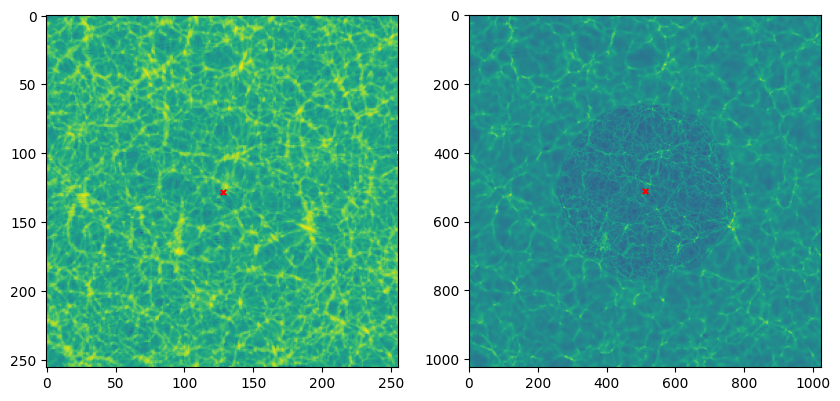

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.log10(density_borg[:,128, :] + 1))
axs[1].imshow(np.log10((density_csiborg.T)[:, 512, :] + 1))

axs[0].scatter([128], [128], c='r', s=15, marker='x')
axs[1].scatter([512], [512], c='r', s=15, marker='x')

plt.show()

In [19]:
(density_csiborg.sum() / (677.7)**3 * 1e-9), (Omega_m * cosmo.critical_density(0).to("Msun/kpc3").value)

(84.92296662181516, 85.20374456447004)

In [21]:

import readgadget

snapshot = "/mnt/users/rstiskalek/csiborgtools/data/chain_17417/chain_17417/ic/ic.dat"

In [22]:
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

# read positions, velocities and IDs of the particles
pos = readgadget.read_block(snapshot, "POS ", ptype) #positions in Mpc/h
vel = readgadget.read_block(snapshot, "VEL ", ptype)     #peculiar velocities in km/s
# ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0
cosmo = FlatLambdaCDM(Om0=Omega_m, H0=100)

In [29]:
# obs_vel = np.array([-262.69592,  326.13116, -122.10088]).astype(np.float32)
obs_vel = np.zeros(3, dtype=np.float32) * 0
obs_loc = np.ones(3) * BoxSize / 2
print("OBS LOC ", obs_loc)
rsp_pos = csiborgtools.utils.real2redshift(pos, vel, obs_loc, obs_vel, BoxSize, True).astype(np.float32)

OBS LOC  [338.3 338.3 338.3]


In [30]:
import numpy as np
import MAS_library as MASL

# number of particles
Np = 256**3

# density field parameters
grid    = 256    #the 3D field will have grid x grid x grid voxels
MAS     = 'CIC'  #mass-assigment scheme
verbose = True   #print information on progress

# particle positions in 3D

# define 3D density field
delta = np.zeros((grid,grid,grid), dtype=np.float32)
delta_rsp = np.zeros((grid,grid,grid), dtype=np.float32)

# construct 3D density field
MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose,)
MASL.MA(rsp_pos, delta_rsp, BoxSize, MAS, verbose=verbose,)

cell_length = BoxSize/grid

delta = delta.T
delta *= Masses[1]
delta /= (cell_length * 1000)**3

delta_rsp = delta_rsp.T
delta_rsp *= Masses[1]
delta_rsp /= (cell_length * 1000)**3


Using CIC mass assignment scheme
Time taken = 0.534 seconds


Using CIC mass assignment scheme
Time taken = 0.495 seconds



In [31]:
print("REAL ", delta.mean() , (cosmo.critical_density(0).to("Msun/kpc3").value * Omega_m))
print("RSP  ", delta_rsp.mean() , (cosmo.critical_density(0).to("Msun/kpc3").value * Omega_m))

delta /= (cosmo.critical_density(0).to("Msun/kpc3").value * Omega_m)
delta -= 1

delta_rsp /= (cosmo.critical_density(0).to("Msun/kpc3").value * Omega_m)
delta_rsp -= 1

REAL  86.33655 86.34164473617794
RSP   86.33636 86.34164473617794


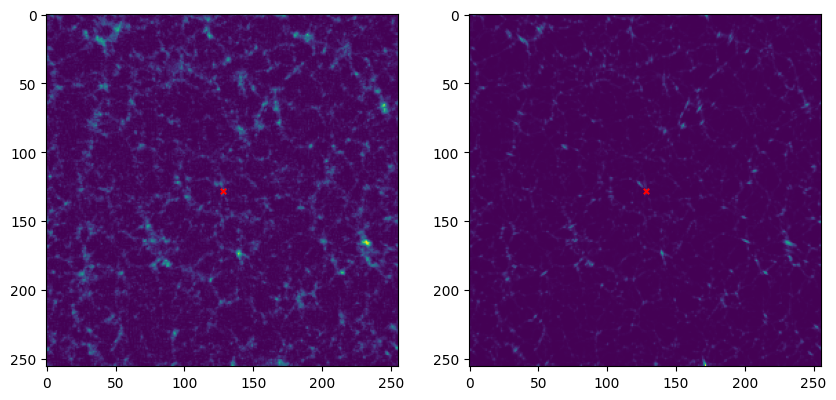

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(delta_rsp[:,:,128])
axs[1].imshow(density_borg[:, :, 128])

for ax in axs:
    ax.scatter([128], [128], c='r', s=15, marker='x')

plt.show()

In [33]:
y_csiborg = []
y_csiborg_rsp = []
y_borg = []

dks = range(0, 128 + 1)
for dk in dks:
    kmin = 128 - dk
    kmax = 128 + dk

    y_csiborg.append(np.mean(delta[kmin:kmax, kmin:kmax, kmin:kmax]))
    y_csiborg_rsp.append(np.mean(delta_rsp[kmin:kmax, kmin:kmax, kmin:kmax]))
    y_borg.append(np.mean(density_borg[kmin:kmax, kmin:kmax, kmin:kmax]))

y_csiborg = np.array(y_csiborg)
y_borg = np.array(y_borg)

/mnt/users/rstiskalek/csiborgtools/venv_csiborg/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/users/rstiskalek/csiborgtools/venv_csiborg/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/mnt/users/rstiskalek/csiborgtools/venv_csiborg/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


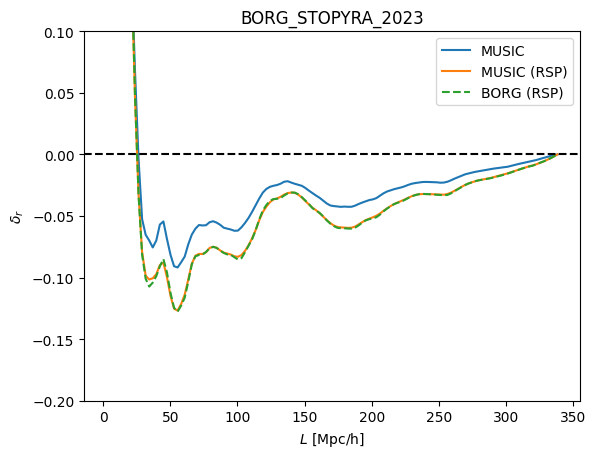

In [37]:
dks_phys = np.array(dks) * (BoxSize/ 256)

plt.figure()
# plt.title("Enclosed overdensity within a cube of side length $2 L$ centered at the origin.", fontsize=10)
plt.title("BORG_STOPYRA_2023")
plt.plot(dks_phys, y_csiborg, label="MUSIC")
plt.plot(dks_phys, y_csiborg_rsp, label="MUSIC (RSP)")
plt.plot(dks_phys, y_borg, label="BORG (RSP)", ls="--")
plt.xlabel(r"$L ~ [\mathrm{Mpc}/\mathrm{h}]$")
plt.ylabel(r"$\delta_r$")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.ylim(-0.2, 0.1)
plt.savefig("../plots/MUSIC_BORG_STOPYRA_comparisong.png", dpi=300)
plt.show()

In [ ]:
a